Training data shape: (891, 12)

Training data sample:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4

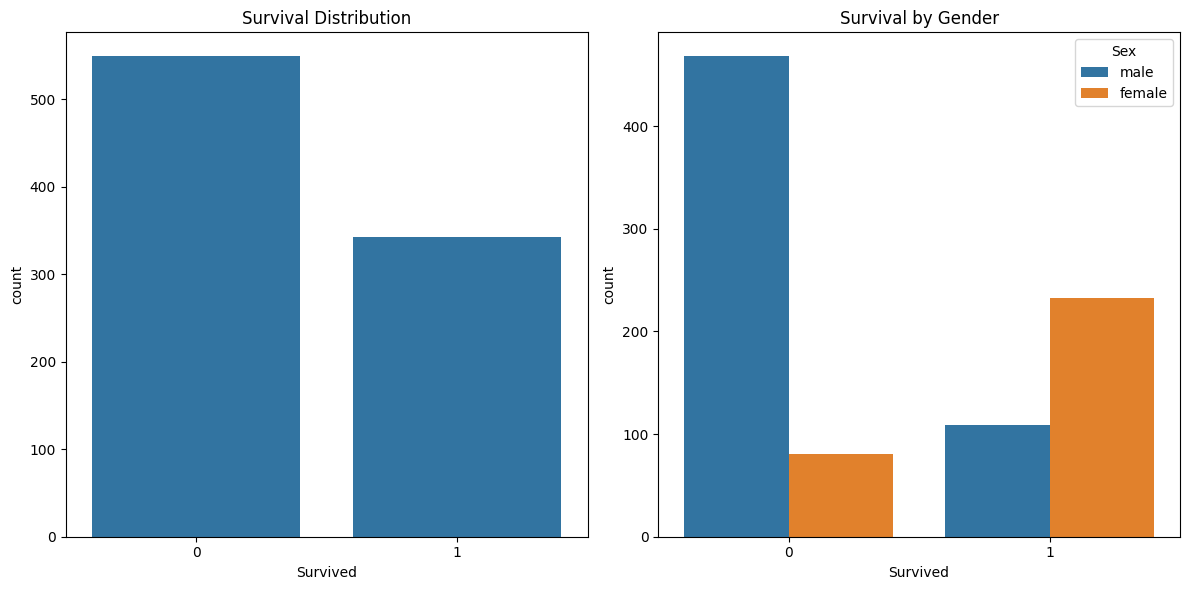

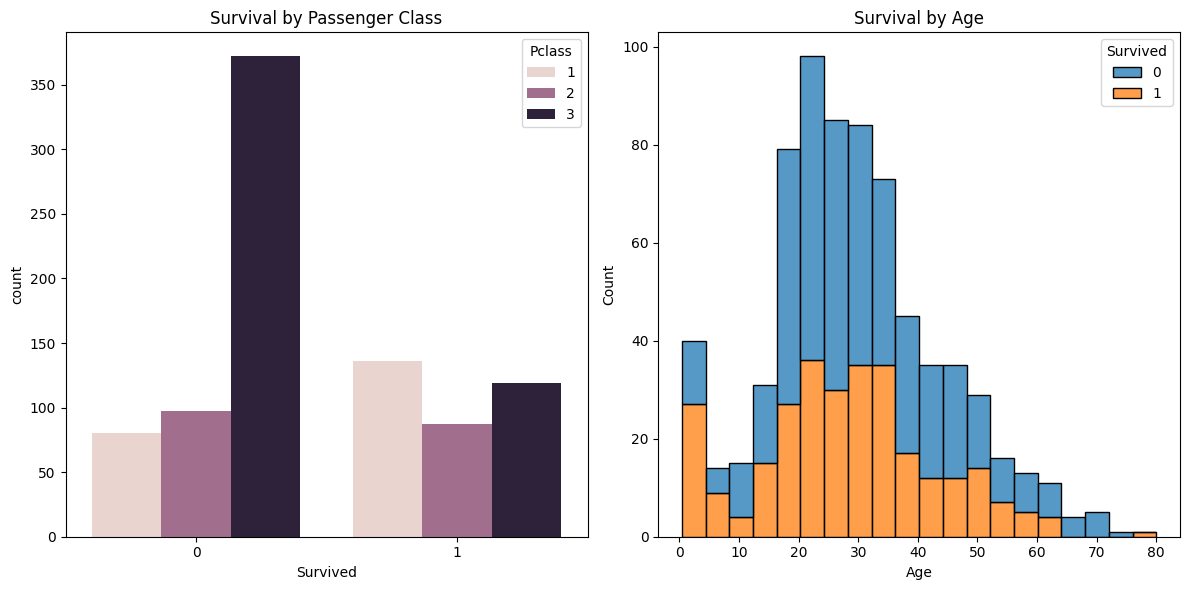

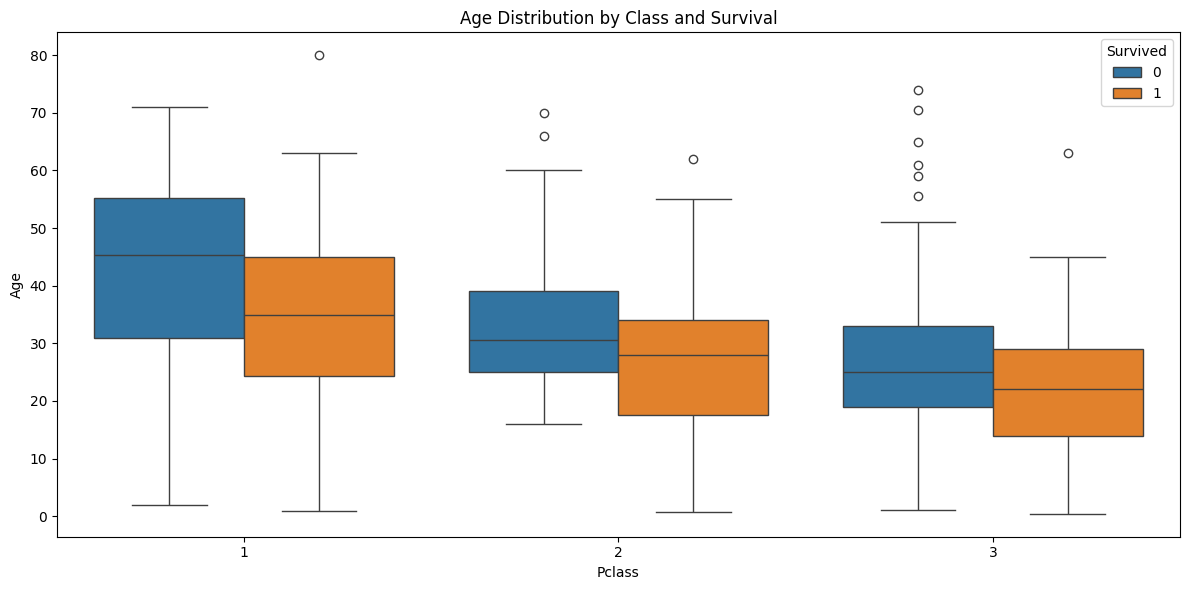


Validation Accuracy: 0.8324

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       105
           1       0.78      0.82      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix:
[[88 17]
 [13 61]]

Submission file created successfully!


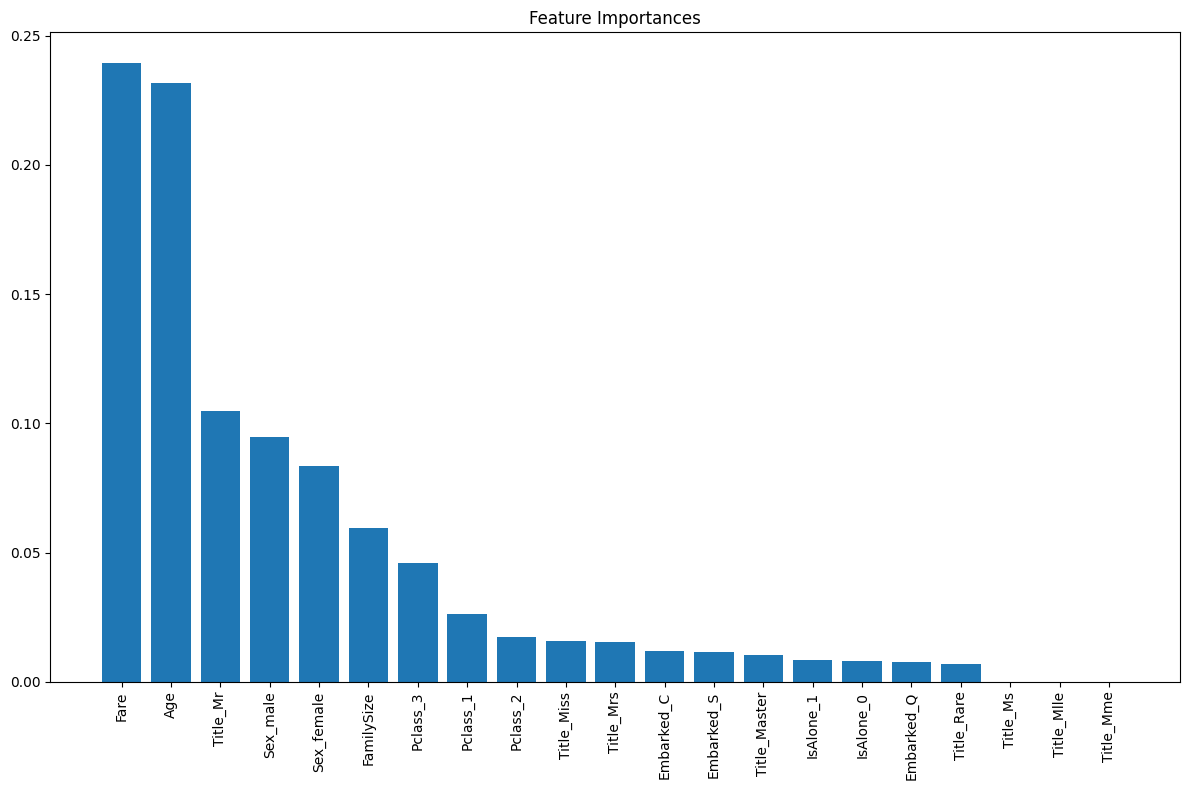


Process completed successfully!


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


np.random.seed(42)


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


print("Training data shape:", train_data.shape)
print("\nTraining data sample:")
print(train_data.head())
print("\nTraining data info:")
print(train_data.info())
print("\nTraining data description:")
print(train_data.describe())
print("\nMissing values in training data:")
print(train_data.isnull().sum())

train_df = train_data.copy()
test_df = test_data.copy()



plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution')

plt.subplot(122)
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title('Survival by Gender')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title('Survival by Passenger Class')

plt.subplot(122)
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack', bins=20)
plt.title('Survival by Age')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=train_df)
plt.title('Age Distribution by Class and Survival')
plt.tight_layout()
plt.show()



def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train_df['Title'] = train_df['Name'].apply(extract_title)
test_df['Title'] = test_df['Name'].apply(extract_title)

rare_titles = ['Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')

train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
X = train_df[features]
y = train_df['Survived']
X_test = test_df[features]

numeric_features = ['Age', 'Fare', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

# Hyperparameter Tuning // commented to save computation time 
"""
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_model = grid_search.best_estimator_
""" 


model.fit(X, y)  # Retrain on the entire training set
y_pred_test = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_test
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")

feature_names = (
    numeric_features + 
    list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
         .get_feature_names_out(categorical_features))
)
importances = model.named_steps['classifier'].feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


print("\nProcess completed successfully!")